<a href="https://colab.research.google.com/github/kukuhpranata/cnn-on-intelimage-dataset/blob/main/Intel_image_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import random

# seed
random.seed(113)
torch.manual_seed(113)
torch.cuda.manual_seed(113)
np.random.seed(113)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
train_dir = "/content/gdrive/My Drive/IntelImage/seg_train/"
test_dir = "/content/gdrive/My Drive/IntelImage/seg_test/"

In [ ]:
img_size = 150

train_transform = transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.RandomRotation(5), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


test_transform = transforms.Compose([
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_img = datasets.ImageFolder(train_dir, transform=train_transform)
test_img = datasets.ImageFolder(test_dir, transform=test_transform)

In [ ]:
print("train_img type   :",type(train_img))
print("train_img length :",len(train_img))
print("test_img length :",len(test_img))
print("train_img classes:",train_img.classes)
print("train_img[0] type:",type(train_img[0]))
print("train_img[0][0] t:",type(train_img[0][0]))
print("train_img[0][1] t:",type(train_img[0][1]))
print("train_img[0][0] s:",train_img[0][0].size())
print("train_img[0][1]  :",train_img[0][1])

n_labels = len(train_img.classes)

train_img type   : <class 'torchvision.datasets.folder.ImageFolder'>
train_img length : 5042
test_img length : 1815
train_img classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
train_img[0] type: <class 'tuple'>
train_img[0][0] t: <class 'torch.Tensor'>
train_img[0][1] t: <class 'int'>
train_img[0][0] s: torch.Size([3, 150, 150])
train_img[0][1]  : 0


In [ ]:
def imshow(data_image, tensor=False):
    image = data_image[0]
    label = data_image[1]
    image = image.numpy().transpose((1, 2, 0))

    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5],)
    image = std * image + mean
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.show()
    
    print(train_img.classes[label])

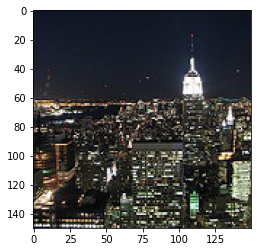

buildings


In [ ]:
imshow(train_img[0])

In [ ]:
trainloaders = torch.utils.data.DataLoader(train_img, batch_size=64, shuffle=True)
testloaders = torch.utils.data.DataLoader(test_img, batch_size=64, shuffle=True)

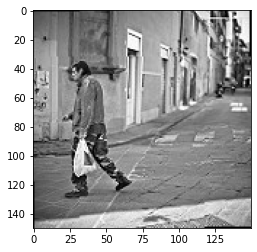

street


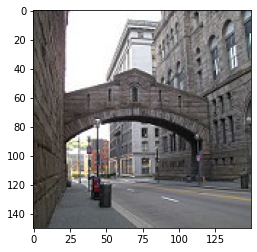

street


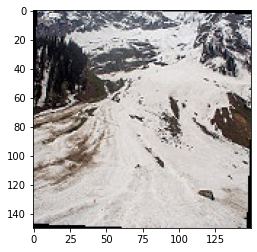

glacier


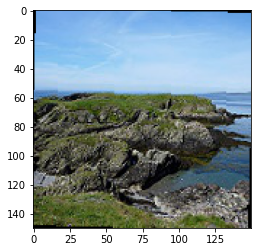

sea


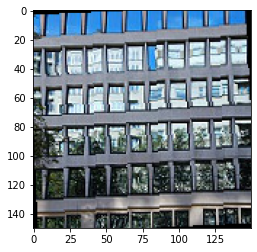

buildings


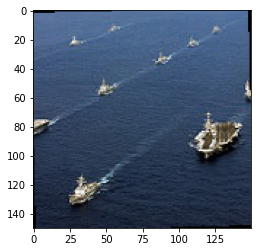

sea


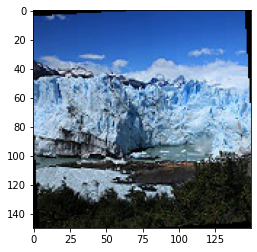

glacier


In [ ]:
for image, label in trainloaders:
    for i in range(7):
        imshow((image[i], label[i]))
    break

In [ ]:

########################
# 1. Neural Net Model using Class (the most common)
#######################
class Net(nn.Module):
    
    def __init__(self, ks=4, ps=3, fm1=16, fm2=32, n=256):
    
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, fm1, kernel_size=ks, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=ps, stride=2, padding=0)
        self.conv2 = nn.Conv2d(fm1, fm2, kernel_size=ks, stride=1, padding=0)
        
        # calculate CNN's output size
        res = self.conv_size(self.conv_size(self.conv_size(self.conv_size(img_size, ks), ps, s=2), ks), ps, s=2)**2*fm2
        
        self.fc1 = nn.Linear(res, n)
        self.fc2 = nn.Linear(n, n_labels)
        self.do = nn.Dropout()

    def conv_size(self, inp, k, p=0, s=1):
        return (inp-k+2*p)//s+1
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1)
        x = self.do(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
    
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=36992, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
  (do): Dropout(p=0.5, inplace=False)
)

In [ ]:
########################
# 2. Neural Net Model using Sequential (for simple network)
#######################

class Flatten(nn.Module):
  
    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        return x
    
model = torch.nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=0),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                        Flatten(),
                        nn.Linear(39200, 512),
                        nn.ReLU(),
                        nn.Dropout(),
                        nn.Linear(512, 25))

model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=39200, out_features=512, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=512, out_features=25, bias=True)
)

In [ ]:
########################
# 3. Neural Net Model using Sequential in Class
#######################

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.features = torch.nn.Sequential(
                            nn.Conv2d(3, 16, kernel_size=4, stride=1, padding=0),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        self.classifier = torch.nn.Sequential(
                            nn.Linear(39200, 512),
                            nn.ReLU(),
                            nn.Dropout(),
                            nn.Linear(512, 25))
    
    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x
    
model = Net()
model.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=39200, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=25, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epoch = 20

In [ ]:
model.train()

for i in range(epoch):
    total_loss = 0
    total_sample = 0    
    total_correct = 0
    
    for image, label in trainloaders:
        image = image.to(device)
        label = label.to(device)
        
        out = model(image)
        
        loss = criterion(out, label)
        total_loss += loss.item()
        total_sample += len(label)
        total_correct += torch.sum(torch.max(out,1)[1]==label).item()*1.0
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("epoch", i, total_loss/total_sample, total_correct/total_sample)

epoch 0 0.02183938364526763 0.5198333994446648
epoch 1 0.013331990365422184 0.6747322491074971
epoch 2 0.01193644670870795 0.7197540658468862
epoch 3 0.010773575333128463 0.739587465291551
epoch 4 0.010286577657686723 0.7514875049583498
epoch 5 0.009214257393645559 0.7822292740975804
epoch 6 0.008511587841460649 0.7935343117810393
epoch 7 0.007825518779837863 0.817929393097977
epoch 8 0.007080462546586896 0.8349861166203887
epoch 9 0.0066254883324849325 0.8439111463704879
epoch 10 0.005783589739309611 0.8645378817929393
epoch 11 0.005340211386011026 0.8758429194763983
epoch 12 0.00492899443766561 0.8869496231654106
epoch 13 0.0043703203711278945 0.8948829829432765
epoch 14 0.004198899828798948 0.9047996826656088
epoch 15 0.0039119213355504915 0.9095596985323284
epoch 16 0.003587628657479269 0.9151130503768345
epoch 17 0.0031544845499532747 0.9262197540658469
epoch 18 0.002850842462296242 0.9329631098770329
epoch 19 0.0024610452497291547 0.9458548195160651


In [ ]:
model.eval()
total_loss = 0
total_sample = 0    
total_correct = 0

for image, label in testloaders:
    image = image.to(device)
    label = label.to(device)
    
    out = model(image)

    loss = criterion(out, label)
    total_loss += loss.item()
    total_sample += len(label)
    total_correct += torch.sum(torch.max(out, 1)[1] == label).item()*1.0


print("test loss", total_loss/total_sample)
print("test accuracy", total_correct/total_sample)

test loss 0.011443144789083601
test accuracy 0.8264462809917356


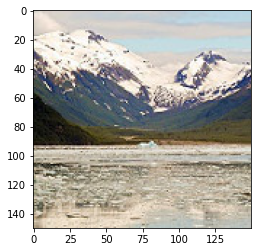

In [ ]:
imagepath = "/content/gdrive/My Drive/IntelImage/23906.jpg"
image_test = Image.open(imagepath)
plt.imshow(image_test)
plt.show()

In [ ]:
image_transformed = test_transform(image_test) 
image_transformed = image_transformed.unsqueeze(0).to(device)
out = model(image_transformed)
print(out)
print("PREDICTION:", train_img.classes[torch.max(out,1)[1]])

tensor([[ -7.8118,  -6.2521,   9.3890,   8.9862,   1.0431,  -1.2971, -20.3795,
         -19.6525, -20.8762, -20.1349, -20.9981, -20.6980, -21.1893, -22.1873,
         -20.9070, -19.3783, -19.3059, -19.9557, -19.6025, -20.0136, -21.3330,
         -21.0457, -20.0422, -21.5837, -20.8062]], grad_fn=<AddmmBackward>)
PREDICTION: glacier


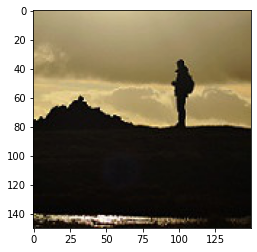

In [ ]:
imagepath = "/content/gdrive/My Drive/IntelImage/21759.jpg"
image_test = Image.open(imagepath)
plt.imshow(image_test)
plt.show()

In [ ]:
image_transformed = test_transform(image_test) 
image_transformed = image_transformed.unsqueeze(0).to(device)
out = model(image_transformed)
print(out)
print("PREDICTION:", train_img.classes[torch.max(out,1)[1]])

tensor([[ -3.1305,  -4.1129,   4.4711,   8.3421,   4.4550,  -4.3758, -16.5869,
         -17.1072, -17.1502, -16.9312, -16.1662, -17.1413, -16.5675, -16.9320,
         -16.4645, -17.1576, -15.6805, -16.3630, -16.8087, -15.0913, -18.1053,
         -16.1163, -16.5367, -17.3379, -16.5954]], grad_fn=<AddmmBackward>)
PREDICTION: mountain


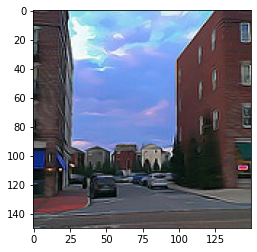

In [ ]:
imagepath = "/content/gdrive/My Drive/IntelImage/22064.jpg"
image_test = Image.open(imagepath)
plt.imshow(image_test)
plt.show()

In [ ]:
image_transformed = test_transform(image_test) 
image_transformed = image_transformed.unsqueeze(0).to(device)
out = model(image_transformed)
print(out)
print("PREDICTION:", train_img.classes[torch.max(out,1)[1]])

tensor([[  6.5602,   2.7845,  -7.2587,  -1.7263,  -0.7024,   9.8587, -18.4642,
         -16.6297, -15.7120, -17.2371, -15.3661, -16.9245, -15.7462, -19.1311,
         -16.3440, -16.3373, -17.2433, -15.2755, -17.6558, -16.1323, -17.7597,
         -15.0316, -17.8566, -17.3378, -16.7085]], grad_fn=<AddmmBackward>)
PREDICTION: street


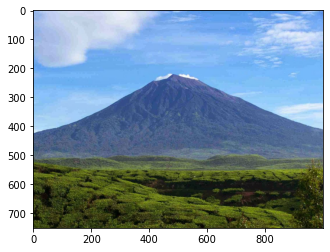

In [ ]:
imagepath = "/content/gdrive/My Drive/IntelImage/large-gunung-kerinci-a05e1da851e221b71264ba26b705bafd.jpg"
image_test = Image.open(imagepath)
plt.imshow(image_test)
plt.show()

In [ ]:
image_transformed = test_transform(image_test) 
image_transformed = image_transformed.unsqueeze(0).to(device)
out = model(image_transformed)
print(out)
print("PREDICTION:", train_img.classes[torch.max(out,1)[1]])

tensor([[ -7.0717,  -7.2990,   5.2141,   8.6556,   8.3938,  -6.5870, -21.1011,
         -20.9243, -19.8982, -19.6893, -20.4588, -21.9197, -20.9407, -22.3406,
         -21.8845, -21.2220, -20.5007, -19.9527, -20.4881, -20.9868, -22.3137,
         -20.4503, -20.5541, -20.3590, -21.4514]], grad_fn=<AddmmBackward>)
PREDICTION: mountain
